In [1]:
import numpy                as np
from os                     import listdir
import matplotlib.pyplot    as plt
import matplotlib           as mpl
import matplotlib.lines     as mlines
from natsort                import natsorted
import os
import json
import CSEmodel as cse

from matplotlib             import rcParams, rc
rcParams.update({'figure.dpi': 200})
rc('font', family='serif')
rc('text', usetex=True)

import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('/STER/silkem/MACE/')
import src.mace.utils as utils
import src.mace.CSE_0D.dataset as ds 

from matplotlib             import rcParams, rc
rcParams.update({'figure.dpi': 200})



def makeOutputDir(path):
    if not os.path.exists(path):
        os.mkdir(path)
    return path

specs_dict, idx_specs = utils.get_specs()



def get_time(dt, idx):
    t = np.zeros(len(dt))
    t[0] = CSEmodel.time[idx]
    for i in range(0,len(t)-1):
        t[i+1] = (dt[i]+t[i])
        
    return np.array(t)



def read_input(infile):

    # with open(infile, 'a') as file:
    #         file.write('\nName = '+name+'\n')

    with open(infile,'r') as f:
        file = f.readlines()
        lines = []
        for line in file:
            lines.append(line.split())

    inputfile = {}
    for i in range(len(lines)):
        if not len(lines[i]) == 0 and len(lines[i]) > 2:
            inputfile[lines[i][0]] = lines[i][2]
        elif not len(lines[i]) == 0 and len(lines[i]) <= 2:
            print('You forgot to give an input for '+lines[i][0])

    return inputfile

def get_conversion():
    with open('specs_UMISTrate16_to_krome.json', 'r') as f:
        conv=f.read()
    conv_dict  = json.loads(conv)

    specs = list()
    idx_krome = list()

    for key in conv_dict:
        specs.append(key)
        idx_krome.append(conv_dict[key][-1])

    return conv_dict, specs, idx_krome

conv_dict, specs, idx_krome = get_conversion()

def get_species(i):
    idx = idx_krome.index(i)

    return specs[idx]

def get_idx(spec):
    return idx_krome[specs.index(spec)]




In [2]:
## Get CSE output
path0D = '/STER/silkem/fortran_0D/'
modname = '20211015_gridC_Mdot1e-6_v17-5_T_eps_model_2022-12-24h17-06-51_step/'

dens = list()

for i in range(1,134):
    # print(i)
    infile = path0D + 'input/' + modname[:-6] + '/krome/input_' + str(i) + '.in'
    input = read_input(infile)
    dens.append(float(input['DN']))

dens = np.array(dens)

abs_umist = list()

for i in range(1, 134):
    # print(i)
    file = path0D + 'rates/'+ modname + 'krome/abs_' + str(i) + '.txt'
    n = np.loadtxt(file, usecols=(2))
    abs_umist.append(n)

abs_umist = np.array(abs_umist).T
abs_ini = abs_umist[:,0].reshape(abs_umist.shape[0],1)



In [10]:
## Get KROME output

krome_modname = '20211015_gridC_Mdot1e-6_v17-5_T_eps_model_2022-12-24h17-06-51/'

path_krome = '/STER/silkem/kromeCSE/data/' 

abs_krome = list()

for i in range(2,134):
    # file = path+str(i)+'.out'
    file = path_krome + krome_modname + 'abs/abs_' + str(i) + '.txt'
    n = np.loadtxt(file)
    abs_krome.append(n)

abs_krome = np.array(abs_krome).T
abs_krome = np.concatenate((abs_ini/dens[0], abs_krome), axis=1)

In [4]:
print(abs_umist.shape,abs_krome.shape)

(468, 133) (468, 133)


In [5]:
spec = 'CO'
idx = get_idx(spec)
print(spec,idx)

abs_krome[idx-1].shape

CO 37


(133,)

CO 37
e- 2
H2 72
H2O 38
OH 46
C2H2 33
C2H 35


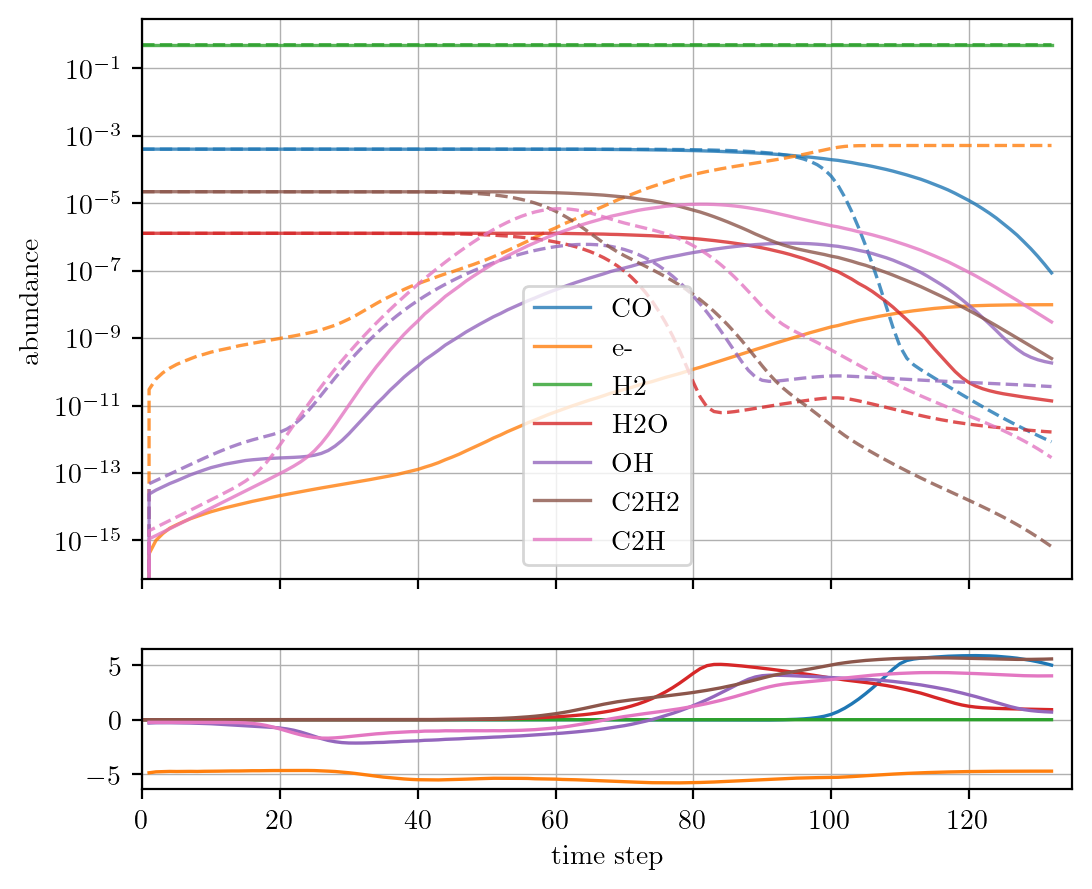

In [11]:
fig, axs = plt.subplots(2,1, gridspec_kw={'height_ratios': [4,1]},figsize=(6, 5))
ax1 = axs[0]
ax2 = axs[1]

species = ['CO',  'e-', 'H2', 'H2O', 'OH', 'C2H2', 'C2H']

alpha = 0.8
ms = 3
lw = 1.2

for spec in species:
    idx = get_idx(spec)
    print(spec,idx)

    krome = abs_krome[idx-1]#/dens[:len(abs_krome[idx-1])]
    umist = abs_umist[idx-1]/dens

    line, = ax1.plot(krome, label = spec, alpha=alpha, ls = '-', lw =lw)
    ax1.plot(umist,  alpha=alpha, lw =lw, ls = '--', color = line.get_color())

    ax2.plot(np.log10(krome)-np.log10(umist[:len(krome)]), color = line.get_color(), lw = lw)

ax1.set_yscale('log')
# ax1.set_ylim(1e-20, 1e-4)

ax1.set_ylabel('abundance')
ax2.set_xlabel('time step')

ax1.set_xlim(0,135)
ax2.set_xlim(0,135)

ax1.xaxis.set_ticklabels([])
ax1.grid(True, lw = 0.5)
ax2.grid(True, lw = 0.5)

# ax1.set_ylim(1e-20, 1e2)

ax1.legend()
plt.show()

In [7]:
s = '/STER/silkem/fortran_0D/out/20211015_gridC_Mdot1e-6_v17-5_T_eps_model_2022-12-24h17-06-51/time/time1.out'

s[-5]

'1'